# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer

# magic word for producing visualizations in notebook
%matplotlib inline

#turn off warnings (e.g. pandas warnings)
import warnings
warnings.filterwarnings("ignore")

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [60]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('Demographics data for the general population of Germany\n',
      'Shape:\n', 'Number of Rows:', azdias.shape[0],
     '\nNumber of Features:', azdias.shape[1])
#check the head of the azdias dataset
azdias.head(n=8)

Demographics data for the general population of Germany
 Shape:
 Number of Rows: 891221 
Number of Features: 85


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0


In [4]:
#Checking info for the azdias dataset
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
# Descriptive statistics  for the azdias dataset
# Only for numeric data
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
print('Demographics data for customers of a mail-order company\n',
      'Shape:\n', 'Number of Rows:', customers.shape[0],
     '\nNumber of Features:', customers.shape[1])
#check the head of the customers dataset
customers.head(n=8)

Demographics data for customers of a mail-order company
 Shape:
 Number of Rows: 191652 
Number of Features: 85


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
5,1,3,1,4.0,5,1,5,1,2,3,...,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
6,2,4,1,2.0,5,1,5,1,1,2,...,3.0,2.0,1.0,0.0,1.0,5.0,5.0,2.0,3.0,2.0
7,1,4,1,2.0,5,1,5,1,2,2,...,3.0,3.0,1.0,1.0,1.0,3.0,3.0,3.0,4.0,3.0


In [7]:
#Checking info for the customers dataset
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

In [8]:
# Descriptive statistics  for the customers dataset
# Only for numeric data
customers.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,191652.000000,191652.000000,191652.000000,188439.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,...,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,141176.000000,141176.000000,141176.000000
mean,0.344359,3.060907,1.376432,3.677928,3.963773,2.057051,4.183317,2.439808,2.646176,2.781176,...,2.537404,2.731510,1.388817,0.539939,1.556607,3.634893,3.622192,2.824850,5.119517,2.898510
std,1.391672,1.086254,0.484492,1.813975,1.036230,1.319422,0.995365,1.697932,1.586506,1.147353,...,0.904927,0.840922,0.885038,0.637048,1.185736,0.933660,1.008472,1.012415,2.159184,1.422683
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,-1.000000,3.000000,1.000000,2.000000,3.000000,1.000000,3.000000,1.000000,1.000000,2.000000,...,2.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,2.000000,4.000000,2.000000
50%,0.000000,3.000000,1.000000,4.000000,4.000000,1.000000,5.000000,2.000000,2.000000,3.000000,...,3.000000,3.000000,1.000000,0.000000,1.000000,3.000000,4.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,6.000000,5.000000,4.000000,5.000000,5.000000,5.000000,3.000000,...,3.000000,3.000000,2.000000,1.000000,1.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.000000


In [9]:
#Check head  and tail: Summary of feature attributes for demographics dataset
display(feat_info)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# Identify missing or unknown data values and convert them to NaNs.
print('Total of missing data in azdias dataset: ', azdias.isna().sum().sum())
nan = azdias.isna().sum()
print('\nTotal of Missing values per Column:\n')
pd.set_option('display.max_rows', None)
nan.sort_values(ascending=False)

Total of missing data in azdias dataset:  4896838

Total of Missing values per Column:



KK_KUNDENTYP             584612
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
KBA05_ANTG4              133324
KBA05_BAUMAX             133324
KBA05_GBZ                133324
MOBI_REGIO               133324
REGIOTYP                 121196
KKK                      121196
PLZ8_ANTG3               116515
PLZ8_ANTG1               116515
PLZ8_GBZ                 116515
PLZ8_ANTG2               116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
W_KEIT_KIND_HH           107602
KBA13_ANZAHL_PKW         105800
CAMEO_INTL_2015           98979
CAMEO_DEU_2015            98979
CAMEO_DEUG_2015           98979
ORTSGR_KLS9               97216
ARBEIT                    97216
RELAT_AB                  97216
ANZ_HH_TITEL              97008
BALLRAUM                  93740
EWDICHTE                  93740
INNENSTADT                93740
GEBAEUDETYP_RASTER        93155
ANZ_HAUSHALTE_AKTIV       93148
GEBAEUDE

In [ ]:
# Transform missing_or_unknown in a list 
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))
# Identify missing or unknown data values and convert them to NaNs
# This part has O(n^2),took about 20 min to Run 
for attribute, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    if missing_values[0] != '':
        for value in missing_values:
            if value.isnumeric() or value.lstrip('-').isnumeric():
                value = int(value)
            azdias.loc[azdias[attribute] == value, attribute] = np.nan

In [12]:
# Compare missing data in raw data and after nan - treatment.
print('Total of missing data in azdias dataset after NaN substitution: ', azdias.isna().sum().sum())
azdias_nan_treated = azdias.isna().sum() 
before_nan_treat = pd.Series(nan, name='Missing in Rawdata')
after_nan_treat = pd.Series(azdias_nan_treated, name='Missing after NaN Treatment')
display(pd.concat([before_nan_treat, after_nan_treat], axis=1))

Total of missing data in azdias dataset after NaN substitution:  8373929


,Missing in Rawdata,Missing after NaN Treatment
AGER_TYP,0,685843
ALTERSKATEGORIE_GROB,0,2881
ANREDE_KZ,0,0
CJT_GESAMTTYP,4854,4854
FINANZ_MINIMALIST,0,0
FINANZ_SPARER,0,0
FINANZ_VORSORGER,0,0
FINANZ_ANLEGER,0,0
FINANZ_UNAUFFAELLIGER,0,0
FINANZ_HAUSBAUER,0,0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
print('Proportion of missing data in each column in %')
nan_proportion = round(((azdias_nan_treated/azdias.shape[0])*100), 2)
nan_proportion = nan_proportion.sort_values(ascending=False)
display(nan_proportion)

Proportion of missing data in each column in %


TITEL_KZ                 99.76
AGER_TYP                 76.96
KK_KUNDENTYP             65.60
KBA05_BAUMAX             53.47
GEBURTSJAHR              44.02
ALTER_HH                 34.81
REGIOTYP                 17.74
KKK                      17.74
W_KEIT_KIND_HH           16.61
KBA05_ANTG4              14.96
KBA05_GBZ                14.96
MOBI_REGIO               14.96
KBA05_ANTG1              14.96
KBA05_ANTG2              14.96
KBA05_ANTG3              14.96
PLZ8_GBZ                 13.07
PLZ8_HHZ                 13.07
PLZ8_BAUMAX              13.07
PLZ8_ANTG4               13.07
PLZ8_ANTG1               13.07
PLZ8_ANTG3               13.07
PLZ8_ANTG2               13.07
SHOPPER_TYP              12.48
VERS_TYP                 12.48
HEALTH_TYP               12.48
NATIONALITAET_KZ         12.15
PRAEGENDE_JUGENDJAHRE    12.14
KBA13_ANZAHL_PKW         11.87
ANZ_HAUSHALTE_AKTIV      11.18
CAMEO_INTL_2015          11.15
CAMEO_DEU_2015           11.15
CAMEO_DEUG_2015          11.15
LP_LEBEN

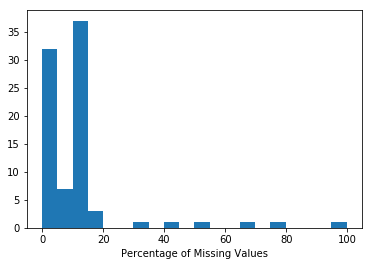

In [14]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(nan_proportion, bins=20)
plt.xlabel('Percentage of Missing Values')
plt.show()

In [15]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
#Selecting columns with more than 30% of missing data to drop
columns_to_drop = nan_proportion[nan_proportion > 30]
display(columns_to_drop)
columns_to_drop = list(columns_to_drop.index.values)

TITEL_KZ        99.76
AGER_TYP        76.96
KK_KUNDENTYP    65.60
KBA05_BAUMAX    53.47
GEBURTSJAHR     44.02
ALTER_HH        34.81
dtype: float64

In [16]:
columns_to_drop

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

In [17]:
#removing columns with more than 30% of missing data from the azdias dataset
azdias_treated = azdias.drop(columns_to_drop, axis=1)
azdias_treated.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [18]:
azdias_treated.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

Most columns have at least 80% of complete data, which is reasonably good when dealing with real-world datasets. 
The dataset has 85 columns, so it was decided to remove columns that have more than 30% of missing data.
We can be more conservative in this case, because we have a large number of variables.
In our specific case, variables with a large amount of missing data seems to add little information to our problem and more hinder than help.
Therefore, it was decided to remove the following variables:

|Feature|Percentage of Missing values (%)|
|---|---|
|TITEL_KZ|99.76|
|AGER_TYP| 76.96|
|KK_KUNDENTYP|65.60|
|KBA05_BAUMAX|53.47|
|GEBURTSJAH|44.02|
|ALTER_HH|34.81|


|Feature|Meaning|
|---|---|
|TITEL_KZ|Academic title flag|
|AGER_TYP|Best-ager typology|
|KK_KUNDENTYP|Consumer pattern over past 12 months|
|KBA05_BAUMAX|Most common building type within the microcell|
|GEBURTSJAH|Year of birth|
|ALTER_HH|Birthdate of head of household|

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [19]:
# How much data is missing in each row of the dataset?
# calculate missing data per row
nans_row = azdias_treated.isna().sum(axis=1)
prop_nans_row = (nans_row/azdias_treated.shape[1])*100
print('Line number\t','Proportion of missing data (%)')
prop_nans_row.head()

Line number	 Proportion of missing data (%)


0    54.430380
1     0.000000
2     0.000000
3     8.860759
4     0.000000
dtype: float64

Text(0.5,0,'Number of Missing Data')

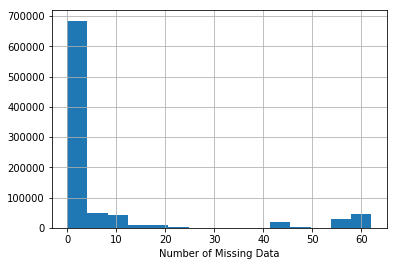

In [20]:
#plot histogram
prop_nans_row.hist(bins = 15)
plt.xlabel('Number of Missing Data')

In [21]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

#Adding the proportion of missing data in the dataset
prop_nans_row = pd.DataFrame (prop_nans_row, columns = ['prop_missing'])
azdias_new_df = azdias_treated.join(prop_nans_row) 

#Separating the dataset in two: Below 30% and Above 30% of row missing data.
azdias_below_30 =  azdias_new_df[azdias_new_df['prop_missing'] <= 30].reset_index(drop=True)
azdias_below_30.drop('prop_missing', axis=1, inplace=True)
azdias_above_30 = azdias_new_df[azdias_new_df['prop_missing'] > 30].reset_index(drop=True)
azdias_above_30.drop('prop_missing', axis=1, inplace=True)

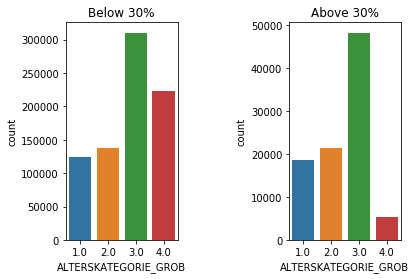

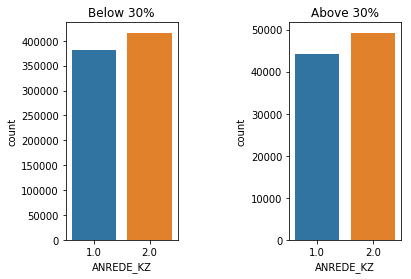

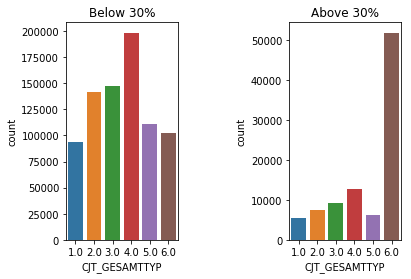

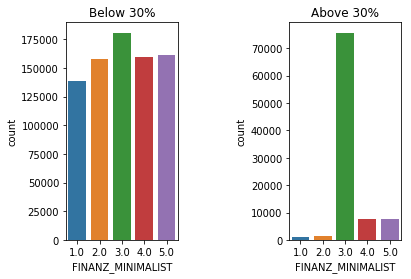

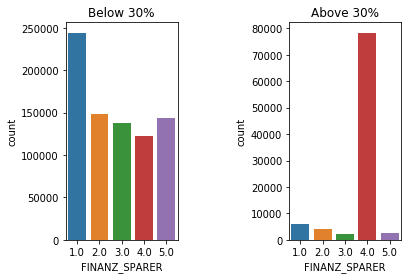

In [22]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare_graph(df1, df2, column):
    fig, ax = plt.subplots(1,2)
    sns.countplot(df1[column], ax=ax[0])
    sns.countplot(df2[column], ax=ax[1])
    ax[0].title.set_text('Below 30%')
    ax[1].title.set_text('Above 30%')
    plt.subplots_adjust(wspace= 1.0)
    fig.show()
#loop thru each features - plotting only 5
for i, col in enumerate(azdias_treated.columns[:5]):
    compare_graph(azdias_below_30, azdias_above_30, col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

The data with lots of missing values are indeed different from data with few or no missing values.
I separeted the data in two groups: one with rows with more than 30% of missing values (azdias_above_30) and the other with rows with less than 30% of missing values.
For variables like FINANZ_MINIMALIST', 'CJT_GESAMTTYP' and 'FINANZ_SPARER',  we can see in the graphs that the distributions of azdias_below_30 and azdias_above_30 are completely different. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [23]:
# How many features are there of each data type?
num_count = feat_info['type'].value_counts()
print(num_count)

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [24]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
for attribute in feat_info[feat_info['type']=='categorical'].attribute:
    if attribute in azdias.columns:
        print(attribute, azdias[attribute].nunique())

AGER_TYP 3
ANREDE_KZ 2
CJT_GESAMTTYP 6
FINANZTYP 6
GFK_URLAUBERTYP 12
GREEN_AVANTGARDE 2
LP_FAMILIE_FEIN 11
LP_FAMILIE_GROB 5
LP_STATUS_FEIN 10
LP_STATUS_GROB 5
NATIONALITAET_KZ 3
SHOPPER_TYP 4
SOHO_KZ 2
TITEL_KZ 5
VERS_TYP 2
ZABEOTYP 6
KK_KUNDENTYP 6
GEBAEUDETYP 7
OST_WEST_KZ 2
CAMEO_DEUG_2015 9
CAMEO_DEU_2015 44


In [25]:
#Checking if feature was dropped
features = list(azdias_below_30.columns)
feat_clean = feat_info[feat_info['attribute'].isin(features)]

# Selecting only categorical
cat_features = feat_clean[feat_clean["type"]=="categorical"]["attribute"]

# Separating binary and Multi-level features
binary = []
multi_level = []
for feature in cat_features:
    if (len(azdias_below_30[feature].unique())==2):
        binary.append(feature)
    elif (len(azdias_below_30[feature].unique())>2):
        multi_level.append(feature)

In [118]:
multi_level

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [27]:
binary

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']

In [28]:
for feature in binary:
    print(feature, azdias_below_30[feature].unique())

ANREDE_KZ [ 2.  1.]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [ 1.  0.]
OST_WEST_KZ ['W' 'O']


In [29]:
# Re-encode categorical variable(s) to be kept in the analysis.
dict_values = {'W': 0, 'O': 1}
azdias_below_30 = azdias_below_30.replace({'OST_WEST_KZ':dict_values})

In [30]:
azdias_below_30['OST_WEST_KZ'].unique()

array([0, 1])

In [31]:
#dropping multi categorical 
azdias_below_30_treat = azdias_below_30.drop(multi_level, axis=1)

In [32]:
azdias_below_30_treat.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [33]:
azdias_below_30_treat.shape

(797837, 65)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

1. I decided to keep all the binary categorical variable: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']
2. I had to re-encode the OST_WEST_KZ variable from  ['W' 'O'] to [0, 1]. 
3. I chose to drop all multi-categorical variables, because we do have a large number of features and they have also many missing data. The multi categorical variables dropped were:
['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [34]:
cat_feat_mix = feat_clean[feat_clean['type'] =='mixed']
display(cat_feat_mix)

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1, 0]"


### PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [35]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_below_30_treat['PRAEGENDE_JUGENDJAHRE'].unique()

array([ 14.,  15.,   8.,   3.,  10.,  11.,   5.,   9.,   6.,   4.,  nan,
         2.,   1.,  12.,  13.,   7.])

In [36]:
# Spliting PRAEGENDE_JUGENDJAHRE column in DECADE and MOVEMENT
# For movement -> Encode: Mainstream = 1, Avantgarde = 0.
azdias_below_30_treat['DECADE'] = azdias_below_30_treat['PRAEGENDE_JUGENDJAHRE']
azdias_below_30_treat['MOVEMENT'] = azdias_below_30_treat['PRAEGENDE_JUGENDJAHRE']

In [37]:
decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6, 0:np.nan, -1:np.nan}
movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0, 0:np.nan, -1:np.nan}

In [38]:
azdias_below_30_treat['DECADE'].replace(decade_dict, inplace=True)
azdias_below_30_treat['MOVEMENT'].replace(movement_dict, inplace=True)

In [39]:
azdias_below_30_treat.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0


In [40]:
azdias_below_30_treat = azdias_below_30_treat.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

In [41]:
azdias_below_30_treat.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0


CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [42]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_below_30_treat['WEALTH'] = azdias_below_30_treat['CAMEO_INTL_2015']
azdias_below_30_treat['LIFE_STAGE'] = azdias_below_30_treat['CAMEO_INTL_2015']

In [43]:
wealth_dict = {11.0:1, 12.0:1, 13.0:1, 14.0:1, 15.0:1, 21.0:2, 22.0:2, 23.0:2, 24.0:2, 25.0:2,
               31.0:3, 32.0:3, 33.0:3, 34.0:3, 35.0:3, 41.0:4, 42.0:4, 43.0:4, 44.0:4, 45.0:4,
               51.0:5, 52.0:5, 53.0:5, 54.0:5, 55.0:5}

life_stage_dict = {11.0:1, 12.0:2, 13.0:3, 14.0:4, 15.0:5, 21.0:1, 22.0:2, 23.0:3, 24.0:4, 25.0:5,
                   31.0:1, 32.0:2, 33.0:3, 34.0:4, 35.0:5, 41.0:1, 42.0:2, 43.0:3, 44.0:4, 45.0:5,
                   51.0:1, 52.0:2, 53.0:3, 54.0:4, 55.0:5}

In [44]:
azdias_below_30_treat['WEALTH'].replace(wealth_dict, inplace=True)
azdias_below_30_treat['LIFE_STAGE'].replace(life_stage_dict, inplace=True)

In [45]:
azdias_below_30_treat = azdias_below_30_treat.drop('CAMEO_INTL_2015', axis=1)

In [46]:
azdias_below_30_treat.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I created two new variabes from PRAEGENDE_JUGENDJAHRE:
1. DECADE: encoded from 1 to 6 each representing a decade.
2. MOVEMENT: encoded like Mainstream = 1, Avantgarde = 0.
I also created two variables from CAMEO_INTL_2015:
1. WEALTH: encoded from 1 to 5 each represeting one social class
2. LIFE_STAGE: encoded from 1 to 5 each representing one Life Stage Typology.

Therefore, I decided to drop the original variables: PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [48]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Dropping the others Mixed-Type Features
features = list(azdias_below_30_treat.columns)
feat_clean = feat_info[feat_info['attribute'].isin(features)]
cat_feat_mix = feat_clean[feat_clean['type'] == 'mixed']
cat_feat_mix = list(cat_feat_mix.attribute.values)
azdias_below_30_treat.drop(cat_feat_mix, axis=1, inplace=True)

In [49]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_below_30_treat.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


In [50]:
print(azdias_below_30_treat.shape)

(797837, 63)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [161]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=";")
    feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))
    for attribute, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        if missing_values[0] != '':
            for value in missing_values:
                if value.isnumeric() or value.lstrip('-').isnumeric():
                    value = int(value)
                df.loc[df[attribute] == value, attribute] = np.nan
    
    # remove selected columns and rows, ...
    #Dropping columns with more than 30% of missing data
    df_nan_treated = df.isna().sum() 
    nan_proportion = round(((df_nan_treated/df.shape[0])*100), 2)
    nan_proportion = nan_proportion.sort_values(ascending=False)
    columns_to_drop = nan_proportion[nan_proportion > 30]
    columns_to_drop = list(columns_to_drop.index.values)
    columns_to_drop.remove('REGIOTYP')
    columns_to_drop.remove('KKK')
    df_treated = df.drop(columns_to_drop, axis=1)
    
    #Adding the proportion of missing data in the dataset
    nans_row = df_treated.isna().sum(axis=1)
    prop_nans_row = (nans_row/df_treated.shape[1])*100
    prop_nans_row = pd.DataFrame(prop_nans_row, columns = ['prop_missing'])
    new_df = df_treated.join(prop_nans_row) 

    #Separating the dataset in two: Below 30% and Above 30% of row missing data.
    below_30 = new_df[new_df['prop_missing'] <= 30].reset_index(drop=True)
    below_30.drop('prop_missing', axis=1, inplace=True)
    above_30 = azdias_new_df[azdias_new_df['prop_missing'] > 30].reset_index(drop=True)
    above_30.drop('prop_missing', axis=1, inplace=True)
    
    # select, re-encode, and engineer column values.
    #Checking if feature was dropped
    features = list(below_30.columns)
    feat_clean = feat_info[feat_info['attribute'].isin(features)]

    # Selecting only categorical
    cat_features = feat_clean[feat_clean["type"]=="categorical"]["attribute"]

    # Separating binary and Multi-level features
    multi_level = []
    for feature in cat_features:
        if (len(azdias_below_30[feature].unique())>2):
            multi_level.append(feature)
            
    below_30_treat = below_30.drop(multi_level, axis=1)
    dict_values = {'W': 0, 'O': 1}
    below_30_treat = below_30_treat.replace({'OST_WEST_KZ':dict_values})
    # Spliting PRAEGENDE_JUGENDJAHRE column in DECADE and MOVEMENT
    # For movement -> Encode: Mainstream = 1, Avantgarde = 0.
    below_30_treat['DECADE'] = below_30_treat['PRAEGENDE_JUGENDJAHRE']
    below_30_treat['MOVEMENT'] = below_30_treat['PRAEGENDE_JUGENDJAHRE']
    decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6, 0:np.nan, -1:np.nan}
    movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0, 0:np.nan, -1:np.nan}
    below_30_treat['DECADE'].replace(decade_dict, inplace=True)
    below_30_treat['MOVEMENT'].replace(movement_dict, inplace=True)
    below_30_treat = below_30_treat.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    below_30_treat['WEALTH'] = below_30_treat['CAMEO_INTL_2015']
    below_30_treat['LIFE_STAGE'] = below_30_treat['CAMEO_INTL_2015']
    
    wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

    life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}
    
    below_30_treat['WEALTH'].replace(wealth_dict, inplace=True)
    below_30_treat['LIFE_STAGE'].replace(life_stage_dict, inplace=True)
    
    below_30_treat = below_30_treat.drop('CAMEO_INTL_2015', axis=1)
    
    # Dropping the others Mixed-Type Features
    features = list(below_30_treat.columns)
    feat_clean = feat_info[feat_info['attribute'].isin(features)]
    cat_feat_mix = feat_clean[feat_clean['type'] == 'mixed']
    cat_feat_mix = list(cat_feat_mix.attribute.values)
    below_30_treat.drop(cat_feat_mix, axis=1, inplace=True)
    
    

    
    # Return the cleaned dataframe.
    return below_30_treat

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [66]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
impute_missing = Imputer(strategy='most_frequent')
azdias_imputed = pd.DataFrame(impute_missing.fit_transform(azdias_below_30_treat))

In [69]:
azdias_imputed.isna().sum().sum()

0

In [72]:
azdias_imputed.columns = azdias_below_30_treat.columns
azdias_imputed.index = azdias_below_30_treat.index

In [73]:
azdias_imputed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


In [132]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler() 
pop_scaled = scaler.fit(azdias_imputed)
azdias_scaled = scaler.fit_transform(azdias_imputed)

In [100]:
azdias_scaled_cols = pd.DataFrame(azdias_scaled)
azdias_scaled_cols.columns = azdias_below_30_treat.columns
azdias_scaled_cols.index = azdias_below_30_treat.index

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

For imputation I chose to use the mode (the most frequent observation), because in this situation that we have numeric and categorical variables the mean does not perform well. 

Regarding feature scaling I chose Standard Scaler – or z-score normalisation. 
Where the Z-Score is calculated as:

$z = \frac{(x - u)}{s}$

The StandardScaler transforms our data in a way that our data's distribution will have a mean value 0 and standard deviation of 1.
When dealing with PCA and clustering which are methods based on variance it is extremelly import to standardize our data.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [104]:
# Apply PCA to the data.
pca = PCA()
pca = pca.fit(azdias_scaled_cols)

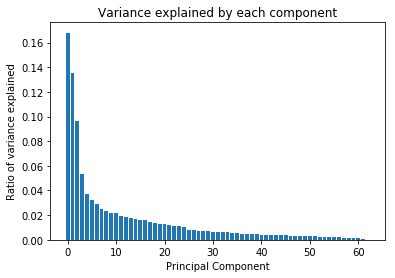

In [105]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal Component")
plt.ylabel("Ratio of variance explained")
plt.show()

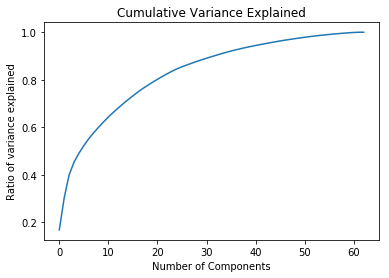

In [106]:
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of variance explained")
plt.show()

In [133]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_35 = PCA(n_components=35)
pop_pca = pca_35.fit(azdias_scaled_cols)
azdias_pca = pca_35.fit_transform(azdias_scaled_cols)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

As we can see in the graphs, 35 is a reasonable number of Principal components to choose, because it explains 92.6 % of our variance.
Considering that we entered a dataset with 63 features, we reduced our dataset size in almost 45%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [111]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_weights(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(azdias_scaled_cols.columns))
    weights = df.iloc[i].sort_values(ascending=False)
    return weights

In [117]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_0 = pca_weights(pca_35, 0)
print(pca_weight_0)

PLZ8_ANTG3               0.225124
PLZ8_ANTG4               0.216663
WEALTH                   0.204485
HH_EINKOMMEN_SCORE       0.202091
ORTSGR_KLS9              0.196391
EWDICHTE                 0.194207
FINANZ_HAUSBAUER         0.159179
FINANZ_SPARER            0.153848
KBA05_ANTG4              0.153784
PLZ8_ANTG2               0.153468
ARBEIT                   0.142391
KBA05_ANTG3              0.136660
ANZ_HAUSHALTE_AKTIV      0.135875
RELAT_AB                 0.134716
SEMIO_PFLICHT            0.122015
SEMIO_REL                0.119532
DECADE                   0.112986
MOVEMENT                 0.110252
SEMIO_RAT                0.100547
SEMIO_TRADV              0.094837
SEMIO_MAT                0.083822
FINANZ_UNAUFFAELLIGER    0.081861
SEMIO_FAM                0.081667
SEMIO_KULT               0.076386
FINANZ_ANLEGER           0.075812
REGIOTYP                 0.060362
OST_WEST_KZ              0.053802
SEMIO_SOZ                0.043534
PLZ8_HHZ                 0.042125
HEALTH_TYP    

In [114]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_sec = pca_weights(pca_35, 1)
print(pca_weight_sec)

ALTERSKATEGORIE_GROB     0.256047
SEMIO_ERL                0.229800
FINANZ_VORSORGER         0.228718
SEMIO_LUST               0.179812
RETOURTYP_BK_S           0.161715
FINANZ_HAUSBAUER         0.122640
SEMIO_KRIT               0.117684
SEMIO_KAEM               0.116810
W_KEIT_KIND_HH           0.114868
PLZ8_ANTG3               0.099555
EWDICHTE                 0.098621
ORTSGR_KLS9              0.097397
PLZ8_ANTG4               0.097304
ANREDE_KZ                0.093585
WEALTH                   0.080283
KBA05_ANTG4              0.075974
SEMIO_DOM                0.074509
ARBEIT                   0.072537
RELAT_AB                 0.069896
PLZ8_ANTG2               0.068877
ANZ_HAUSHALTE_AKTIV      0.067137
HH_EINKOMMEN_SCORE       0.062917
FINANZ_MINIMALIST        0.058387
WOHNDAUER_2008           0.058141
KBA05_ANTG3              0.051283
ANZ_HH_TITEL             0.032232
OST_WEST_KZ              0.028009
MOVEMENT                 0.018974
PLZ8_HHZ                 0.015984
REGIOTYP      

In [115]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_sec = pca_weights(pca_35, 2)
print(pca_weight_sec)

SEMIO_VERT               0.344671
SEMIO_SOZ                0.261906
SEMIO_FAM                0.248830
SEMIO_KULT               0.233889
FINANZ_MINIMALIST        0.154494
RETOURTYP_BK_S           0.109030
FINANZ_VORSORGER         0.101739
W_KEIT_KIND_HH           0.085130
ALTERSKATEGORIE_GROB     0.079684
SEMIO_REL                0.067684
SEMIO_LUST               0.064503
SEMIO_MAT                0.055706
ORTSGR_KLS9              0.050295
EWDICHTE                 0.049504
PLZ8_ANTG4               0.049213
PLZ8_ANTG3               0.048441
GREEN_AVANTGARDE         0.047098
ARBEIT                   0.037367
RELAT_AB                 0.034367
PLZ8_ANTG2               0.032688
WOHNDAUER_2008           0.032636
WEALTH                   0.030222
KBA05_ANTG4              0.030005
ANZ_HAUSHALTE_AKTIV      0.026824
OST_WEST_KZ              0.016325
ANZ_HH_TITEL             0.013921
KBA05_ANTG3              0.011905
ANZ_TITEL                0.009617
PLZ8_HHZ                 0.005623
SOHO_KZ       

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

According to the Sklearn documentation pca.components_ is the principal axes in feature space, representing the directions of maximum variance in the Data.
Thus, the pca.components_ sign only suggest the direction of the correlation between the component and the variable. 
Thefore, as PCA is a linear transformation, the linear relationship between the PC and a specific variable can be expressed as the correlation, which could be positive or negative too.
1. **First principal Component**

**Strong Positive Correlared Variables**: {PLZ8_ANTG3, PLZ8_ANTG4, WEALTH, HH_EINKOMMEN_SCORE, ORTSGR_KLS9, EWDICHTE}

**Strong Negative Correlared Variables**: {PLZ8_ANTG1, MOBI_REGIO, FINANZ_MINIMALIST, KBA05_GBZ, KBA05_ANTG1}

2. **Second principal Component**

**Strong Positive Correlared Variables**: {ALTERSKATEGORIE_GROB, SEMIO_ERL, FINANZ_VORSORGER, SEMIO_LUST, RETOURTYP_BK_S}

**Strong Negative Correlared Variables**: {SEMIO_REL, DECADE, FINANZ_SPARER, SEMIO_TRADV, FINANZ_UNAUFFAELLIGER, SEMIO_PFLICHT}

3. **Third principal Component**

**Strong Positive Correlared Variables**:{SEMIO_VERT, SEMIO_SOZ,SEMIO_FAM, SEMIO_KULT, FINANZ_MINIMALIST, ETOURTYP_BK_S, INANZ_VORSORGER}

**Strong Negative Correlared Variables**: {ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT, SEMIO_RAT, FINANZ_ANLEGER, SEMIO_ERL}


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [120]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
def get_kmeans_score(data, center):
    #Instantialize Kmeans
    kmeans = KMeans(n_clusters=center)
    # Fits the model to the dataset
    model = kmeans.fit(data)
    # Get the score related to the model fit
    score = np.abs(model.score(data))
    return score

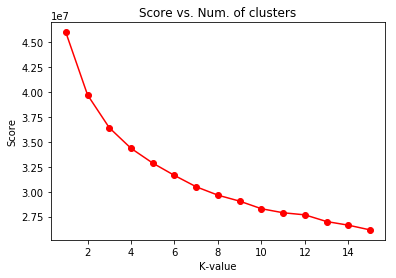

In [126]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
# Over a number of different cluster counts...

#initialize values scores and n of centers
scores = []
centers = list(range(1,16))

#looping thru all the centers
for center in centers:
    scores.append(get_kmeans_score(azdias_pca, center))
#Plotting Score vs. Number of clusters
plt.plot(centers, scores, linestyle='-', marker='o', color='r');
plt.xlabel('K-value');
plt.ylabel('Score');
plt.title('Score vs. Num. of clusters');

In [127]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=9)
gen_pop_kmeans = kmeans.fit(azdias_pca)
pop_cluster_pred = gen_pop_kmeans.predict(azdias_pca)

In [129]:
pop_cluster_pred

array([2, 7, 7, ..., 6, 4, 3], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

To determine the optimal number of clusters we usually use the "**Elbow Method**".
The **Elbow Method** consists in selecting the **value of k** at the "elbow" that is the point after which the distortion of the line start decreasing in a linear behavior. Thus for the given data, we conclude that the optimal number of clusters is 9.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [162]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=";")
# Cleaning the dataset with clean_data function. 
customers_clean = clean_data(customers)

In [165]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Missing Values imputation with mode.
customers_imputed = pd.DataFrame(impute_missing.fit_transform(customers_clean))
customers_imputed.columns = customers_clean.columns
customers_imputed.index = customers_clean.index
# Apply feature scaling to the customer population demographics data.
customers_scaled = pop_scaled.transform(customers_imputed)
customers_scaled_cols = pd.DataFrame(customers_scaled)
customers_scaled_cols.columns = customers_clean.columns
customers_scaled_cols.index = customers_clean.index
#Apply PCA
customers_pca = pop_pca.transform(customers_scaled_cols)
#Kmeans
customers_cluster_pred = gen_pop_kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'General Population Clusters')

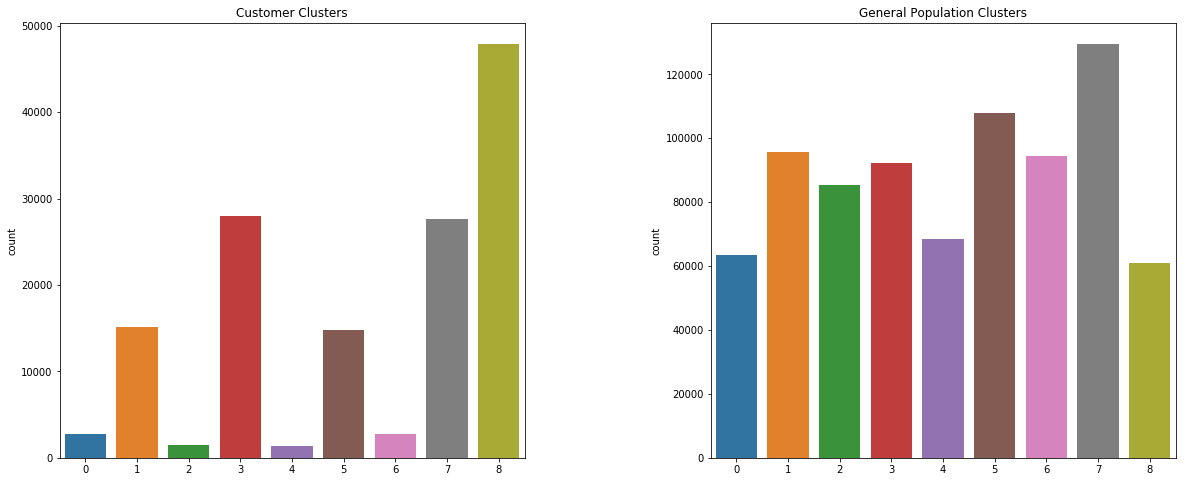

In [174]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (20,8))
figure.subplots_adjust(wspace=0.4)
sns.countplot(customers_cluster_pred, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(pop_cluster_pred, ax=axs[1])
axs[1].set_title('General Population Clusters')

In [181]:
cust_df = pd.DataFrame(customers_cluster_pred, columns=['Cluster']).reset_index().groupby('Cluster').count() / len(customers_cluster_pred)*100
pop_df = pd.DataFrame(pop_cluster_pred, columns=['Cluster']).reset_index().groupby('Cluster').count()/len(pop_cluster_pred)*100
cust_df.rename({'index':'Customer Percentage'}, axis=1, inplace=True)
pop_df.rename({'index':'Population Percentage'}, axis=1, inplace=True)
merged_df = cust_df.join(pop_df)
merged_df = merged_df.sort_values(by=['Cluster'])
display(merged_df)

,Customer Percentage,Population Percentage
Cluster,,
0,1.917567,7.957264
1,10.651422,12.005836
2,1.059355,10.686644
3,19.728986,11.575297
4,0.975369,8.572177
5,10.418519,13.510028
6,1.930976,11.822340
7,19.493260,16.240661
8,33.824547,7.629754


In [210]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_2 = pop_scaled.inverse_transform(pop_pca.inverse_transform(gen_pop_kmeans.cluster_centers_[8]))
overrepresented = pd.Series(data = centroid_2, index = customers_clean.columns)

In [211]:
overrepresented.sort_values(ascending = False)

MIN_GEBAEUDEJAHR         1993.012828
KBA13_ANZAHL_PKW          690.610854
WOHNDAUER_2008              8.547201
SEMIO_VERT                  6.212678
ORTSGR_KLS9                 5.407939
SEMIO_LUST                  5.307495
SEMIO_KULT                  4.893101
SEMIO_FAM                   4.858847
SEMIO_SOZ                   4.828559
FINANZ_MINIMALIST           4.819250
INNENSTADT                  4.557473
W_KEIT_KIND_HH              4.220663
FINANZ_VORSORGER            4.177073
SEMIO_ERL                   4.119975
BALLRAUM                    4.026398
KBA05_GBZ                   4.018289
MOBI_REGIO                  4.015014
SEMIO_MAT                   3.988758
EWDICHTE                    3.978685
GEBAEUDETYP_RASTER          3.946821
PLZ8_GBZ                    3.880096
RETOURTYP_BK_S              3.761364
SEMIO_REL                   3.738676
PLZ8_HHZ                    3.682783
DECADE                      3.608387
REGIOTYP                    3.587136
LIFE_STAGE                  3.557200
S

In [212]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_4 = pop_scaled.inverse_transform(pop_pca.inverse_transform(gen_pop_kmeans.cluster_centers_[4]))
underrepresented = pd.Series(data = centroid_4, index = customers_clean.columns)

In [213]:
underrepresented.sort_values(ascending = False)

MIN_GEBAEUDEJAHR         1992.617198
KBA13_ANZAHL_PKW          526.610708
ANZ_HAUSHALTE_AKTIV        16.121605
WOHNDAUER_2008              7.158405
ORTSGR_KLS9                 6.985552
SEMIO_KULT                  6.736271
SEMIO_FAM                   6.637591
SEMIO_SOZ                   6.555540
SEMIO_REL                   6.183678
SEMIO_VERT                  5.956788
DECADE                      5.718130
SEMIO_PFLICHT               5.535455
HH_EINKOMMEN_SCORE          5.508632
EWDICHTE                    5.165297
SEMIO_MAT                   5.018844
REGIOTYP                    4.966000
SEMIO_TRADV                 4.698254
W_KEIT_KIND_HH              4.559196
WEALTH                      4.450373
FINANZ_SPARER               4.348060
SEMIO_RAT                   4.029787
FINANZ_UNAUFFAELLIGER       3.747131
PLZ8_HHZ                    3.745669
RELAT_AB                    3.738966
ARBEIT                      3.696333
FINANZ_HAUSBAUER            3.591593
FINANZ_ANLEGER              3.553633
G

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

The clusters fitted in the Mail-order company dataset was mostly categorised into cluster 8
The company main target are the people of cluster 8 who are old with restricted movement and come from limited wealth.
This makes sense because these people have mobility issue hence are provided on door service and have limited resources so can't afford expensive services.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [ ]:
!!jupyter nbconvert *ipynb